# Exercise 8: Sound transformations

In this exercise you will use the HPS model to creatively transform sounds. There are two parts in this exercise. In the first one you should perform a natural sounding transformation on the speech sound that you used in the previous exercise (E7). In the second part you should select a sound of your choice and do a "creative" transformation. You will have to write a short description of the sound and of the transformation you did, giving the link to the original sound and uploading several transformed sounds.

For this exercise, you can use the `transformations_GUI.py` (in `software/transformations_interface/`) to try things, once decided you can fill up the code in this file. You can also do everything from here and add any new code you wish.

In order to perform a good/interesting transformation you should make sure that you have performed an analysis that is adequate for the type of transformation you want to do. Not every HPS analysis representation will work for every type of sound transformation. There will be things in the analysis that when modified will result in undesired artifacts. In general, for any transformation, it is best to have the harmonic values as smooth and continuous as possible and an stochastic representation as smooth and with as few values as possible. It might be much better to start with an analysis representation that does not result in the best reconstruction in exchange of having smoother and more compact data.

To help you with the exercise, we give a brief description of the transformation parameters used by the HPS transformation function:

1. `freqScaling`: frequency scaling factors to be applied to the harmonics of the sound, in time-value pairs (where value of 1 is no scaling). The time values can be normalized, from 0 to 1, or can correspond to the times in seconds of the input sound. The scaling factor is a multiplicative factor, thus a value of 1 is no change. Example: to transpose an octave the sound you can specify `[0, 2, 1, 2]`.
2. `freqStretching`: frequency stretching factors to be applied to the harmonics of the sound, in time-value pairs (value of 1 is no stretching). The time values can be normalized, from 0 to 1, or can correspond to the times in seconds of the input sound. The stretching factor is a multiplicative factor whose effect depend on the harmonic number, higher harmonics being more affected that lower ones, thus resulting in an inharmonic effect. A value of 1 results in no transformation. Example: an array like `[0, 1.2, 1, 1.2]` will result in a perceptually large inharmonic effect.
3. `timbrePreservation`: 1 preserves the original timbre, 0 does not. It can only have a value of 0 or of 1. By setting the value to 1 the spectral shape of the original sound is preserved even when the frequencies of the sound are modified. In the case of speech it would correspond to the idea of preserving the identity of the speaker after the transformation.
4. `timeScaling`: time scaling factors to be applied to the whole sound, in time-value pairs (value of 1 is no scaling). The time values can be normalized, from 0 to 1, or can correspond to the times in seconds of the input sound. The time scaling factor is a multiplicative factor, thus 1 is no change. Example: to stretch the original sound to twice the original duration, we can specify `[0, 0, 1, 2]`.

All the transformation values can have as many points as desired, but they have to be in the form of an array with time-value pairs, so of even size. For example a good array for a frequency stretching of a sound that has a duration of 3.146 seconds could be: `[0, 1.2, 2.01, 1.2, 2.679, 0.7, 3.146, 0.7]`.

## Part 1. Perform natural sounding transformations of a speech sound

Use the HPS model with the sound `speech-female.wav`, available in the sounds directory, to first analyze and then obtain a natural sounding transformation of the sound. The synthesized sound should sound as different as possible to the original sound while sounding natural. By natural we mean that it should sound like speech, that it could have been possible to be produced by a human, and by listening we should consider it as a speech sound, even though we might not be able to understand it. You should first make sure that you start from a good analysis, then you can do time and/or frequency scaling transformations. The transformation should be done with a single pass, no mixing of sounds coming from different transformations. Since you used the same sound in A7, use that experience to get a good analysis, but consider that the analysis, given that we now want to use it for applying a very strong transformation, might be done differently than what you did in A7.

Write a short paragraph for every transformation, explaining what you wanted to obtain and explaining the transformations you did, giving both the analysis and transformation parameter values (sufficiently detailed for the evaluator to be able to reproduce the analysis and transformation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
sys.path.append('../software/transformations/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import hpsTransformations as HPST
import harmonicTransformations as HT
import IPython.display as ipd
import math  # added
import harmonicModel as HM  # added for F0 detection

In [2]:
# 1.1 perform an analysis/synthesis using the HPS model

input_file = '../sounds/speech-female.wav'

### set the parameters
window ='blackmanharris'
M = 2075
N = 4096
t = -80
minSineDur = 0.01
nH = 20
minf0 = 130
maxf0 = 235
f0et = 30
harmDevSlope = 0.3
stocf = 0.5

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

"""
Computing the freqScaling, freqStretching and timeScaling pairs values arrays for the next part.

See next part for an explanation.
"""
phonems_time_locations = np.array([0.15, 0.37, 0.63, 1.01, 1.14, 1.4, 1.6, 1.9, 2.4, 2.54, 2.76, 3.25, 3.48, 3.7])
file_dur = len(x) / fs
norm_phonems_time_locations = phonems_time_locations / file_dur

lfos_f = 10 # of course the period of the LFO is relative to the input signal length
lfo1_values_at_phonems_time_locations = np.cos(2 * np.pi * lfos_f * norm_phonems_time_locations)
lfo1_min_range = -0.2 # time scaling between - 0.2 sec and + 0.8 sec
lfo1_max_range = 0.8
lfo1_values_at_phonems_time_locations = np.interp(lfo1_values_at_phonems_time_locations, (lfo1_values_at_phonems_time_locations.min(), lfo1_values_at_phonems_time_locations.max()), (lfo1_min_range, lfo1_max_range))
lfo1_values_at_phonems_time_locations = np.round(lfo1_values_at_phonems_time_locations, 2)

lfo2_values_at_phonems_time_locations = np.cos(2 * np.pi * lfos_f * norm_phonems_time_locations)
lfo2_min_range = 0.25 # freq scaling between -2 octaves and + 2.5 octaves
lfo2_max_range = 2.5
lfo2_values_at_phonems_time_locations = np.interp(lfo2_values_at_phonems_time_locations, (lfo2_values_at_phonems_time_locations.min(), lfo2_values_at_phonems_time_locations.max()), (lfo2_min_range, lfo2_max_range))
lfo2_values_at_phonems_time_locations = np.round(lfo2_values_at_phonems_time_locations, 2)

lfo3_values_at_phonems_time_locations = np.cos(2 * np.pi * lfos_f * norm_phonems_time_locations)
lfo3_min_range = 0.9 # freq stretch +- 10 per cent
lfo3_max_range = 1.1
lfo3_values_at_phonems_time_locations = np.interp(lfo3_values_at_phonems_time_locations, (lfo3_values_at_phonems_time_locations.min(), lfo3_values_at_phonems_time_locations.max()), (lfo3_min_range, lfo3_max_range))
lfo3_values_at_phonems_time_locations = np.round(lfo3_values_at_phonems_time_locations, 2)

print("File duration (secs)")
print(file_dur)
print("Phonems locations")
print(phonems_time_locations)
print("Phonems locations (normalized time)")
print(norm_phonems_time_locations)

print("Lfo 1 minimum range")
print(lfo1_min_range)
print("Lfo 1 max range")
print(lfo1_max_range)
print("Lfo 1 values at phonems locations")
print(lfo1_values_at_phonems_time_locations)


print("Lfo 2 minimum range")
print(lfo2_min_range)
print("Lfo 2 max range")
print(lfo2_max_range)
print("Lfo 2 values at phonems locations")
print(lfo2_values_at_phonems_time_locations)

print("Lfo 3 minimum range")
print(lfo3_min_range)
print("Lfo 3 max range")
print(lfo3_max_range)
print("Lfo 3 values at phonems locations")
print(lfo3_values_at_phonems_time_locations)

### explain your parameter choices
"""
    I have basically taken the same parameters used in the H + S model of assignment n. 7, but,
    in order to make the harmonic model sound "brighter" (I think the previous version
    missed some upper harmonics), I incresaed a little bit the number of harmonics.

    The lowest f0 (used to calculate M) and f0 ranges,
    like assignment 7, have been understood by looking at the STFT spectrogram.
"""

File duration (secs)
3.9938321995464854
Phonems locations
[0.15 0.37 0.63 1.01 1.14 1.4  1.6  1.9  2.4  2.54 2.76 3.25 3.48 3.7 ]
Phonems locations (normalized time)
[0.03755791 0.09264285 0.15774323 0.25288994 0.28544013 0.35054052
 0.40061773 0.47573356 0.6009266  0.63598065 0.69106559 0.81375477
 0.87134357 0.92642851]
Lfo 1 minimum range
-0.2
Lfo 1 max range
0.8
Lfo 1 values at phonems locations
[-0.06  0.75 -0.14 -0.19  0.61 -0.2   0.8   0.32  0.8  -0.02  0.72  0.62
  0.19  0.26]
Lfo 2 minimum range
0.25
Lfo 2 max range
2.5
Lfo 2 values at phonems locations
[0.58 2.38 0.38 0.27 2.06 0.25 2.5  1.43 2.5  0.66 2.33 2.11 1.12 1.27]
Lfo 3 minimum range
0.9
Lfo 3 max range
1.1
Lfo 3 values at phonems locations
[0.93 1.09 0.91 0.9  1.06 0.9  1.1  1.   1.1  0.94 1.08 1.06 0.98 0.99]


'\n    I have basically taken the same parameters used in the H + S model of assignment n. 7, but,\n    in order to make the harmonic model sound "brighter" (I think the previous version\n    missed some upper harmonics), I incresaed a little bit the number of harmonics.\n\n    The lowest f0 (used to calculate M) and f0 ranges,\n    like assignment 7, have been understood by looking at the STFT spectrogram.\n'

In [3]:
# 1.2 Perform a transformation from the previous analysis
""""""
def merge_arrays_as_pairs(a, b):
    if (len(a) != len(b)):  
        raise ValueError("merge_arrays_as_pairs() -> arrays must be of equal length")
    
    c = []
    for element in range(0, len(a)):
        c = np.append(c, a[element])
        c = np.append(c, b[element])
    return np.array(c)

### define the transformations
freqScaling = merge_arrays_as_pairs(phonems_time_locations, lfo2_values_at_phonems_time_locations)
print("Frequency scaling array;")
print(freqScaling)

freqStretching = merge_arrays_as_pairs(phonems_time_locations, lfo3_values_at_phonems_time_locations)
print("Frequency strecthing array;")
print(freqStretching)

timbrePreservation = 1 # it goes without saying, I prefer to preserve as much as possible the original spectrum shape

timeScaling = merge_arrays_as_pairs(phonems_time_locations, phonems_time_locations + lfo1_values_at_phonems_time_locations)
# insert [0, 0] at the beginning of array in order to properly map and format the values (it means start mapping time 0 in input sound to time 0 in output sound)
timeScaling = np.insert(timeScaling, 0, 0)
timeScaling = np.insert(timeScaling, 0, 0)
print("Time scaling array;")
print(timeScaling)

# no need to modify the following code 
Ns = 512
H = 128

# frequency scaling of the harmonics 
hfreqt, hmagt = HT.harmonicFreqScaling(hfreq, hmag, freqScaling, freqStretching, timbrePreservation, fs)

# time scaling the sound
yhfreq, yhmag, ystocEnv = HPST.hpsTimeScale(hfreqt, hmagt, stocEnv, timeScaling)

# synthesis from the trasformed hps representation 
y, yh, yst = HPS.hpsModelSynth(yhfreq, yhmag, np.array([]), ystocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=y, rate=fs))

### explain your transformations
"""
The main idea behind the transformations I want to do is keeping track of the phonems' "onsets"
present in the speech-female.wav sound, and apply transformations at those time points.
The transformations envelopes (direction of transformation and "steepness" of the curve)
are "controlled" with LFOs; basically, some LFOs cosine-shaped-waveform are "sampled" at the phonems onsets
time points, and those values are used to shape the transormations envelopes of time scaling, frequency scaling
and frequency strecthing.

All LFOs have the same frequency (so that the "direction" of the transformation is the same across different
tranformations, e.g. all tranformed parameters increase or decrease together at the same time location),
but different "amplitude" ranges, tweaked specifically for each parameter dimension
(e.g. frequency stretch has a very much narrower range of transformations comparing to frequency scaling).
The difference between transformations also consist on the time scaling being an addition,
while the frequency transformations are a multiplication.
A mapping to a negative time value (smaller than the starting map in the input sound) means shrinking that time gap,
while a positive time value means enlarging the time gap between the original phonemes.
I decided the time scaling range to be between -0.2 and + 0.8 so that the phonems are not "executed" too quickly
in the output sound.
I think applying transformations on the phonems onsets
(to me it's like keeping the "rhythmic" variations, even though the durations and the rhythmic structure
is of course pretty much changed)
guarantees that the original "speech quality" of the sound
is maintained, regardless of how deep the transformations themselves might be.
In fact, the phonems maintain a minimum level of intellegibility in the output sound.

The main intent behind this is to modify the sound in a "structured", "patterned"  way, 
heavily varyating the input sound (while keeping the "speech" nature of the sound) but also
exploiting some latent "structure" altready present in the original sound (e.g., the rhythmic onsets of the phonemes).

Manually extracted time events (phonems onsets);

[0.15, 0.37, 0.63, 1.01, 1.14, 1.4, 1.6, 1.9, 2.4, 2.54, 2.76, 3.25, 3.48, 3.7]

Finally, I like to have everything controllable progragmatically
(the transformations parameters arrays fed into the functions are not computed by hand, but by coding),
so that I can change 
transformations parameters and ranges just by tweaking the value of a variable and re-executing the code.
This is also what I meant by "transforming" with a pattern, with a structure;
not only in the way variables (time scaling, frequency scaling and stretch) behave
through time changing at the same time, but also how they can be controlled in order to experiment different results.

Try to change the LFOs ranges and frequency !!
"""

Frequency scaling array;
[0.15 0.58 0.37 2.38 0.63 0.38 1.01 0.27 1.14 2.06 1.4  0.25 1.6  2.5
 1.9  1.43 2.4  2.5  2.54 0.66 2.76 2.33 3.25 2.11 3.48 1.12 3.7  1.27]
Frequency strecthing array;
[0.15 0.93 0.37 1.09 0.63 0.91 1.01 0.9  1.14 1.06 1.4  0.9  1.6  1.1
 1.9  1.   2.4  1.1  2.54 0.94 2.76 1.08 3.25 1.06 3.48 0.98 3.7  0.99]
Time scaling array;
[0.   0.   0.15 0.09 0.37 1.12 0.63 0.49 1.01 0.82 1.14 1.75 1.4  1.2
 1.6  2.4  1.9  2.22 2.4  3.2  2.54 2.52 2.76 3.48 3.25 3.87 3.48 3.67
 3.7  3.96]


'\nThe main idea behind the transformations I want to do is keeping track of the phonems\' "onsets"\npresent in the speech-female.wav sound, and apply transformations at those time points.\nThe transformations envelopes (direction of transformation and "steepness" of the curve)\nare "controlled" with LFOs; basically, some LFOs cosine-shaped-waveform are "sampled" at the phonems onsets\ntime points, and those values are used to shape the transormations envelopes of time scaling, frequency scaling\nand frequency strecthing.\n\nAll LFOs have the same frequency (so that the "direction" of the transformation is the same across different\ntranformations, e.g. all tranformed parameters increase or decrease together at the same time location),\nbut different "amplitude" ranges, tweaked specifically for each parameter dimension\n(e.g. frequency stretch has a very much narrower range of transformations comparing to frequency scaling).\nThe difference between transformations also consist on the t

### Explain Part 1

## Part 2. Perform creative transformations with a sound of your choice

Pick any natural and harmonic sound from Freesound and use the HPS model to do the most creative and interesting transformation you can come up with. Sounding as different as possible from the original sound.

It is essential that you start with a natural harmonic sound. Examples include (but not limited to) any acoustic harmonic instrument, speech, harmonic sound from nature, etc. As long as they have a harmonic structure, you can use it. You can even reuse the sound you used in A7-Part2 or upload your own sound to freesound and then use it.

The sound from Freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples.

You can do any interesting transformation with a single pass. It is not allowed to mix sounds obtained from different transformations. The transformed sound need not sound natural. So, time to show some creativity!

Write a short paragraph for every transformation, explaining what you wanted to obtain and explaining the transformations you did, giving both the analysis and transformation parameter values (sufficiently detailed for the evaluator to be able to reproduce the analysis and transformation).

In [4]:
# 1.1 perform an analysis/synthesis using the HPS model

### set the parameters
input_file = '../sounds/92002__jcveliz__violin-origional.wav' # original freesound file name
window ='blackmanharris'
M = 821 # 8 * (44100 / 430) = 820, chosen 821 for 0 phase windowing. Then I lowered it (a lot :)) with trial and error
N = 1024 # next power of 2 bigger than M
t = -80 # If I make this higher, upper harmonics start to not be properly picked by the harmonic model, and they fall into the stochastic model, which should only contain the bow rubbing sound
minSineDur = 0.08
nH = 35 
minf0 = 430
maxf0 = 1000
f0et = 5 # vibrato taken into account by looking at the spectrogram and with some trial and error
harmDevSlope = 0.05
stocf = 0.5

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

### explain your parameter choices
"""
Window type:
I chose Blackmanharris because, even with this wide-main-lobe window, M is not too large
(Better in order to obtain a good frequency resolution with lowest side lobes when possible).

Window size;
Following the formula, M should be not less than 8 * (44100 / 430) = 820 (821 for 0 phase windowing).
In fact, since the signal is monophonic and harmonic, the smallest delta is equal to the lowest F0
(actually, the F0 is slightly higher than 430 hZ, but I put some tolerance).

FFT size;
simply, the smallest power of 2 bigger than M.

Minimum f0 (see also part 2.2);
the lowest pitche in the melody is an A4 (440 hZ), but I chose 430 hZ in order to apply some tolerance.

Maximum f0 (see also part 2.2);
the highest note in the melody is a B5, so I chose 1000 hZ applying a little bit of tolerance above that frequency.

Error threshold in f0 detection (see also part 2.2);
It is a violin sound, so vibratos should be taken into account
(prominent approximately at t = 2.0 and t = 3.5) more than other type of instruments, but anyway this value
should not be too high; the value has been choosen by looking at the spectrogram first, and then with some little
trial and error.

Number of harmonics;
Again, I think we should include as many harmonic as possible here, in order for the harmonic model to be as complete
as possible, and for the residual/stochastic model to not "occupy" the "harmonic" and louder frequencies
(which I think in this type of sound are occupied by the harmonic model); anyway, it does not make any difference
to increase this number above 35, confirmed with trial and error, while lowering this number (e.g. 30 harmonics)
makes the harmonic model frequency spectrum poorer in high frequencies, and thus the stochastic model tends to occupy
too much the upper spectrum.

Stochastic decimation factor;
I find that a stochastic decimation factor of 1/2 (0.5 means 1 sample taken every 2 samples of the residual sound)
works better in this case.
"""

'\nWindow type:\nI chose Blackmanharris because, even with this wide-main-lobe window, M is not too large\n(Better in order to obtain a good frequency resolution with lowest side lobes when possible).\n\nWindow size;\nFollowing the formula, M should be not less than 8 * (44100 / 430) = 820 (821 for 0 phase windowing).\nIn fact, since the signal is monophonic and harmonic, the smallest delta is equal to the lowest F0\n(actually, the F0 is slightly higher than 430 hZ, but I put some tolerance).\n\nFFT size;\nsimply, the smallest power of 2 bigger than M.\n\nMinimum f0 (see also part 2.2);\nthe lowest pitche in the melody is an A4 (440 hZ), but I chose 430 hZ in order to apply some tolerance.\n\nMaximum f0 (see also part 2.2);\nthe highest note in the melody is a B5, so I chose 1000 hZ applying a little bit of tolerance above that frequency.\n\nError threshold in f0 detection (see also part 2.2);\nIt is a violin sound, so vibratos should be taken into account\n(prominent approximately at 

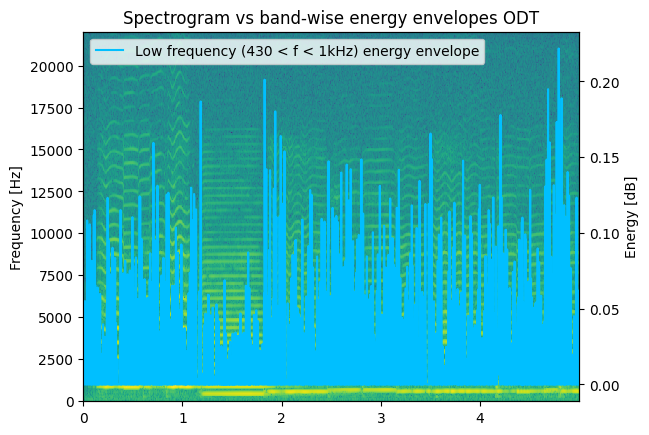

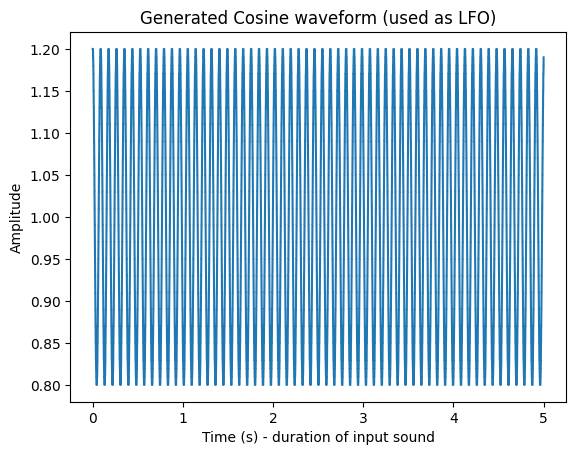

In [ ]:
# 1.2 Perform a transformation from the previous analysis

# Since I want to use the Onset Detection Function of week 4, I paste here some code from a previous notebook
# The 2 frequency-bands ODF has been adapted for this violin freesound sound, so that
# the lower frequency band spans from minf0 (430 hZ) to maxf0 (1000 hZ)

# I am spending time re-adapting the ODF and also computing the time values of the onsets,
# so that it is done programatically and not by hand (for the sake of re-usability)

def compute_eng_env(input_file, window, M, N, H):
    """Compute band-wise energy envelopes of a given audio signal using the STFT.
    
    Args:
        input_file (string): input sound file (monophonic with sampling rate of 44100)
        window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
        M (integer): analysis window size (odd positive integer)
        N (integer): FFT size (power of 2, such that N > M)
        H (integer): hop size for the stft computation
        
    Result:
        np.array: magnitude spectra of sound (2D array)
        np.array: 2D numpy array with energy envelope of band 0 < f < 3000 Hz (in dB) in first column, [:,0]
        np.array: energy envelope of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    
    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    
    # mX is a matrix containing the magnitude spectrum for all frames
    # pX is a matrix containing the phase spectrum for all frames
    mX_dB, pX = STFT.stftAnal(x, w, N, H)
    # Transform mX from dB (logarithmic) into linear scale
    # line of code from dftModel.py
    # mX = 20 * np.log10(absX)  # magnitude spectrum of positive frequencies in dB
    # Linear / logarithmic scales conversion formula:
    # 𝑎⋅log𝑏(𝑥)=log𝑏(𝑥 to the power of 𝑎)
    mX = np.log10(np.power(mX_dB, 20))
    
    num_frames = np.shape(mX)[0]
    
    # Compute, for each frequency bin, the frequency it represents in hZ
    fq_bins = np.arange(N)
    fq_bins_f = fq_bins * (fs / N)

    # find frequency bands' upper and lower borders frequency bins
    for k in range(len(fq_bins_f)):
        if (fq_bins_f[k] > minf0):
            lfBand_lf = k
            break
            
        # count backwards
    for k in range(len(fq_bins_f)-1, 0, -1):
        if (fq_bins_f[k] < maxf0):
            lfBand_hf = k
            break
            
    for k in range(len(fq_bins_f)):
        if (fq_bins_f[k] > maxf0):
            hfBand_lf = k
            break
            
        # count backwards
    for k in range(len(fq_bins_f)-1, 0, -1):
        if (fq_bins_f[k] < 10000):
            hfBand_hf = k
            break
    
        # OPTIONAL debug
        """
    print("lfBand_lf;")
    print(lfBand_lf)
    print("lfBand_hf;")
    print(lfBand_hf)
    print("hfBand_lf;")
    print(hfBand_lf)
    print("hfBand_hf;")
    print(hfBand_hf)
        """
    
        # OPTIONAL debug
    """
    print("mX shape;")
    print(mX.shape)
    """
    # Python/Numpy's arrays and 2-D matrices are accessed and sliced by giving 2 indeces;
    # 1 for the number of row, 1 for the number of column
    # The mX matrix has numberOfFrames rows and fftSize/2 columns (we could say that the time dimension
    # increases from the top row to the bottom row, and the frequency dimension increases from the
    # left column to the right column)
    
    # So, we have to produce 2 matrices, both of which have to have the same number of rows
    # (corresponding to the same number of frames)
    # but different number of columns, depending on the selected frequency bins of the filtered bands
    
    
    lfBand_mX = np.zeros((num_frames, (lfBand_hf-lfBand_lf) + 1))
    """
    print("lfBand_mX shape;")
    print(lfBand_mX.shape)
    """
    for row_it in range(num_frames):
        lfBand_mX[row_it][:] = mX[row_it][lfBand_lf:lfBand_hf+1]
        
    hfBand_mX = np.zeros((num_frames, (hfBand_hf-hfBand_lf) + 1))
    """
    print("hfBand_mX shape;")
    print(hfBand_mX.shape)
    """
    for row_it in range(num_frames):
        hfBand_mX[row_it][:] = mX[row_it][hfBand_lf:hfBand_hf+1]

    # Computer Energy envelope for each frame
    # Since, for each frame, it is the sum of the amplitude of all frequencies, it is not a matrix anymore, but an array
    E_lfBand = np.zeros(num_frames)
    for l in range(num_frames):
        for k in range(np.shape(lfBand_mX)[1]):
            E_lfBand[l] += np.square(lfBand_mX[l,k])
        
    E_hfBand = np.zeros(num_frames)
    for l in range(num_frames):
        for k in range(np.shape(hfBand_mX)[1]):
            E_hfBand[l] += np.square(hfBand_mX[l,k])
        
    bands_E_envelope = np.zeros((num_frames,2))
    for l in range(num_frames):
        bands_E_envelope[l,0] = E_lfBand[l]
        bands_E_envelope[l,1] = E_hfBand[l]
        
    # Converting back the Energy to logarithmic scale
    # 𝐸𝑑𝐵=10log10(𝐸)
    bands_E_envelope = 10 * np.log10(bands_E_envelope)
    
    """
    print("bands_E_envelope shape;")
    print(bands_E_envelope.shape)
    """
    
    return bands_E_envelope # array with num_frames rows and 2 columns (1 for each frequency band)

def compute_odf(input_file, window, M, N, H):
    """Compute a simple onset detection function (ODF) using the STFT.
    
    Args:
        input_file (str): input sound file (monophonic with sampling rate of 44100)
        window (str): analysis window type (rectangular, triangular, hanning, hamming, blackman, or blackmanharris)
        M (int): analysis window size (odd integer value)
        N (int): fft size (power of two, bigger or equal than than M)
        H (int): hop size for the STFT computation
        
    Result:
            np.array: magnitude spectra of sound (2D array)
            np.array: D numpy array with ODF computed in band 0 < f < 3000 Hz (in dB) in first column, [:,0]
            np.array: ODF computed of band 3000 < f < 10000 Hz (in dB) in second column [:,1]
    """
    
    ### your code here
    fs, x = UF.wavread(input_file)
    w = get_window(window, M)
    
    # mX is a matrix containing the magnitude spectrum for all frames
    # pX is a matrix containing the phase spectrum for all frames
    mX, pX = STFT.stftAnal(x, w, N, H)
    num_frames = np.shape(mX)[0]
    
    envE = compute_eng_env(input_file, window, M, N, H)

    # calculating onset detection function
    # The ODF is a series of scalar values, one for each frame, telling us the difference in energy
    # for each consecutive frame (each frame is compared to the previous one)
    # For each frame, it is the difference between the current frame's energy
    # and the previous frame's energy
    ODF = np.zeros((num_frames,2))
    
    # l represents the frame/time iterator (rows)
    # 0 and 1 represents the columns of the matrix (0 -> lower band, 1 -> upper band)
    for l in range(1, num_frames):
        ODF[l][0] = envE[l][0] - envE[l-1][0]
        # half way rectification of lower band (detect only on-sets, not off-sets)
        if (ODF[l][0] < 0.0):
            ODF[l][0] = 0.0
        ODF[l][1] = envE[l][1] - envE[l-1][1]
        # half way rectification of upper band (detect only on-sets, not off-sets)
        if (ODF[l][1] < 0.0):
            ODF[l][1] = 0.0
            
    """
    # normalize
    ODF[:][0] = ODF[:][0] / max(ODF[:][0])
    ODF[:][1] = ODF[:][1] / max(ODF[:][1])
    """
    
    return ODF

# generate a (co)sine wave with duration t(s), sampling rate fs, frequency f and amplitude A
def gen_cosine(f, fs, t, amp_min_range, amp_max_range):
    T = 1.0 / fs # waveform time period

    num_samples = int(fs * t)
    y = np.empty(num_samples)
    for n in range(0, num_samples):
        y[n] = np.cos(2 * np.pi * f * (n * T))
    
    # scale amplitude between given ranges
    y = np.interp(y, (y.min(), y.max()), (amp_min_range, amp_max_range))
    y = np.round(y, 2)
    
    plt.title("Generated Cosine waveform (used as LFO)")
    plt.xlabel("Time (s) - duration of input sound")
    plt.ylabel("Amplitude")
    plt.plot(np.arange(0.0, t, T), y)
    plt.show()
    
    return y

# Generate new, proportionally linearly stretched onsets. This function proportionally stretches the durations of the notes in the input sound
# Unlike the other jupyter notebook, this version, for time scaling,
# does not add or subtract offsets from the original rhythmic onsets,
# but it actually stretches (multiplies) the previous notes durations proportionally
def gen_stretched_onsets(onsets_time_points, onsets_time_points_multipliers):
    if (len(onsets_time_points) != len(onsets_time_points_multipliers)):  
        raise ValueError("gen_stretched_onsets() -> arrays must be of equal length")
    
    stretched_onsets = np.array(onsets_time_points)
    for onset in range(len(onsets_time_points)):
        if (onset == 0):
            onset_dur = onsets_time_points[onset]
        else:
            onset_dur = onsets_time_points[onset] - onsets_time_points[onset - 1]
        
        onset_stretched_dur = onset_dur * onsets_time_points_multipliers[onset]
        if (onset == 0):
            stretched_onsets[onset] = onset_stretched_dur
        else:
            stretched_onsets[onset] = stretched_onsets[onset - 1] + onset_stretched_dur
    
    print("Onsets time points")
    print(onsets_time_points)
    print("Onsets time points multipliers")
    print(onsets_time_points_multipliers)
    print("Stretched onsets")
    print(stretched_onsets)
            
    return stretched_onsets

############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

plot_title = "Spectrogram vs band-wise energy envelopes ODT"
mX, pX = STFT.stftAnal(x, w, N, H)
odf = compute_odf(input_file, window, M, N, H)

#print("Onset detection function;")
#print(odf)

# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mX.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mX.shape[1]) * fs / (2 * mX.shape[1])

(fig, ax) = plt.subplots()
ax2 = ax.twinx()
ax.pcolormesh(tAxis, fAxis, mX.transpose())
ax.set_ylabel('Frequency [Hz]')
ax2.plot(tAxis, odf[:,0], color = 'deepskyblue', label = "Low frequency (430 < f < 1kHz) energy envelope")
# ax2.plot(tAxis, odf[:,1], color = 'darkorange',label = "High frequency (1kHz < f < 10kHz) energy envelope")
ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title(plot_title)
plt.legend()
plt.show()

# Calculate ODF's onsets time points
onset_detection_threshold = 0.055 # tweaked with some trial and error (16 notes in input sound, 16 onsets, this thresholds seems working pretty well)
onsets_frame_n = np.argwhere(odf[:, 1] > onset_detection_threshold)
#print("Onsets indeces")
#print(onsets_frame_n)
# convert onsets frame number into absolute time (s) of note onsets
onsets_time_points = (onsets_frame_n * H) / fs
onsets_time_points = onsets_time_points.flatten() # convert into a 1-D numpy array
#print("Onsets time points")
#print(onsets_time_points)

### define the transformations
############################################################################################################################
############################################################################################################################
############################################################################################################################
##############################################################################################
# I SUMMARIZE HERE ALL THE (TWEAKABLE) PARAMETERS FOR THE TRANSFORMATIONS RANDOM NUMBER GENERATORS (try some changes and re-generate the sound !!)
# frequency scaling parameters (LFO - vibrato effect)
lfo_f_max_range = 15
lfo_f_min_range = 10
lfo_amp_max_range = 1.2
lfo_amp_min_range = 0.8
# frequency stretch parameters
freq_stretch_multiplier_max_range = 0.1
freq_stretch_multiplier_min_range = 0.05
# time scaling parameters (as relative note-length multiplier)
notes_duration_multiplier_min_range = 0.5 # don't use negative values here e.g. 0.5 means half the rhythmic durations
notes_duration_multiplier_max_range = 0.5 # e.g. 2 means double the rhythmic durations
##############################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

lfo_f = np.random.uniform(low=lfo_f_min_range, high=lfo_f_max_range, size=(1))
file_dur = (len(x) / fs) # calculate file duration in seconds
lfo = gen_cosine(lfo_f, fs, file_dur, lfo_amp_min_range, lfo_amp_max_range)
num_samples_in_LFO_cycle = math.floor(int(len(x) / len(lfo)))
# delete last element
input_sound_time_samples_to_map_to_lfo = x[0::num_samples_in_LFO_cycle]
freqScaling = merge_arrays_as_pairs(input_sound_time_samples_to_map_to_lfo, lfo)
print("LFO (used to apply vibrato to frequency scaling) computed random frequency;")
print(lfo_f)
print("Frequency scaling array;")
print(freqScaling)

f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et) 
f0 = (np.rint(f0)).astype(int)
#print("F0;")
#print(f0)
# compute frames time stamps (in seconds, the time each frame is located)
frames_time_stamps = x[0::H]
frames_time_stamps = frames_time_stamps / fs
# map transform amount between chosen ranges
freq_stretch_multiplier = np.random.uniform(low=freq_stretch_multiplier_min_range, high=freq_stretch_multiplier_max_range, size=(1))
# create array of input-output sound mappings
freqStretching = merge_arrays_as_pairs(frames_time_stamps, f0 * freq_stretch_multiplier)
print("Frequency sretching array;")
print(freqStretching)
timbrePreservation = 1

onsets_time_points_multipliers = np.random.uniform(low=notes_duration_multiplier_min_range, high=notes_duration_multiplier_max_range, size=(len(onsets_time_points)))
# create array of input-output sound mappings
timeScaling = merge_arrays_as_pairs(onsets_time_points, gen_stretched_onsets(onsets_time_points, onsets_time_points_multipliers))
# insert [0, 0] at the beginning of array in order to properly map and format the values (it means start mapping time 0 in input sound to time 0 in output sound)
timeScaling = np.insert(timeScaling, 0, 0)
timeScaling = np.insert(timeScaling, 0, 0)
print("Time scaling array;")
print(timeScaling)

# no need to modify anything after this
Ns = 512
H = 128

# frequency scaling of the harmonics 
hfreqt, hmagt = HT.harmonicFreqScaling(hfreq, hmag, freqScaling, freqStretching, timbrePreservation, fs)

# time scaling the sound
yhfreq, yhmag, ystocEnv = HPST.hpsTimeScale(hfreqt, hmagt, stocEnv, timeScaling)

# synthesis from the trasformed hps representation 
y, yh, yst = HPS.hpsModelSynth(yhfreq, yhmag, np.array([]), ystocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=y, rate=fs))

# plot output sound spectrogram
mY, pY = STFT.stftAnal(y, w, N, H)
# calculate time (x) axis unit values for plotting (for each index from 0 to number of frames, multiply by hop size and normalize with respect to sampling frequency)
tAxis = np.arange(mY.shape[0]) * H / fs
# calculate time (y) axis unit values for plotting 
fAxis = np.arange(mY.shape[1]) * fs / (2 * mY.shape[1])

(fig, ay) = plt.subplots()
ay.pcolormesh(tAxis, fAxis, mY.transpose())
ay.set_ylabel('Frequency [Hz]')
#ax2.plot(tAxis, odf[:,0], color = 'deepskyblue', label = "Low frequency (430 < f < 1kHz) energy envelope")
#ax2.plot(tAxis, odf[:,1], color = 'darkorange',label = "High frequency (1kHz < f < 10kHz) energy envelope")
#ax2.set_ylabel('Energy [dB]')
plt.xlim(0, tAxis[-1])
plt.title("TRANSFORMED SOUND")
# plt.legend()
plt.show()

### explain your transformations
"""
Since I like Generative Music Algorithms (where the composer is more an
algorithm designer, more focused on the general compositive procedure that models the music,
rather than on a particular instance of the music itself), and ever-changing music (music that,
while maintaining the same compositional approach/style/algorithm,
it is not the same every time is played),
in this exercise I would like to introduce some (constrained, linearly distributed) randomness, so that,
even though some "compositive" and "transformational" procedures/algorithms are exactly the same,
the output sound is different every time the code is executed.
The main objective is to create an output sound that, being different from the input sound and
different every time the creation algorithm is run, it nevertheless maintain a constant coherence (over
the same instance of output sound, and also across all the possible instances of output sound) with
the input sound. That is, the input sound is transformed and varied, but some of its original quality
is kept within the new sound.
The algorithm has been first thought and designed "arbitrarily",
then the single parameters (ranges for random numbers
generators for the 3 transforms) have been fine-tuned by hear and trial and error.

Similarly to part 1, I want to exploit the original sound's rhythm (the note onsets) to have fixed time points in the
input sound where to apply transformations.
This time, I perform the onset detection programatically (see analysis part), for re-usability.

The time scaling algorithm should be probably called time stretching. 
In fact, differently from the previous version, here the notes durations are stretched proportionally.
Ranges of min and max values, inputted by the user, are used to generate random values within those ranges.
The random values are treated as multipliers for the notes durations.
e.g. if we set the minimum and maximum multiplier range to be the same, let's say at 2, all notes durations will be doubled.

I apply a vibrato to the frequency scaling, by modulating the frequency scaling parameter with an LFO.
Unlike part 1, though, where only liner "envelopes" were created out of the LFO's amplitude values
correspondent to the onsets (the LFO's waveform were "sampled" at the time points of the onsets),
here the onsets are ignored, since I modulate the frequency scaling parameter in a vibrato-like fashion,
in a "continuous" way, from time 0 to the end of the sound.

Then, I detect the F0 (I reused the code from Lab 6) in order to modulate the frequency stretch parameter with it;
different notes will sound more or less harmonic.
Specifically, since frequency stretch is directly proportional to F0 pitch,
higher pitch will stretch frequencies further, so higher pitches will sound more inharmonic.

I designed and applied everything progragmatically rather than "by hand", so that this procedure is re-usable,
adaptable to different needs and
(even though the harmonic + stochastic analysis might need to be re-done with different, ad-hoc parameters)
abstractable for any input sound.
If using a harmonic sound with the same range of F0s (430 hZ - 1000 hZ), the analysis parameters don't need to be changed.
"""